In [ ]:
!pip install einops matplotlib

In [ ]:
!git commit -am "refactoring"; git push

In [ ]:
from copy import deepcopy
import os
import io
import warnings
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation

import torch
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from einops import rearrange

import numpy as np
from IPython.display import display
from itertools import chain

def multiplex(latents: torch.Tensor, K: int) -> torch.Tensor:
    """
    Rearrange the latents tensor into a KxK grid using the einops rearrange function.

    Parameters
    ----------
    latents: torch.Tensor
        The latent tensors to be rearranged.
    K: int
        The grid size for rearrangement.

    Returns
    -------
    torch.Tensor
        The rearranged latents in a KxK grid.
    """
    return rearrange(latents, '(b k1 k2) h w c -> b (k1 h) (k2 w) c', k1=K, k2=K)


def demultiplex(images: torch.Tensor, K: int) -> torch.Tensor:
    """
    Rearrange the images tensor back from a KxK grid using the einops rearrange function.

    Parameters
    ----------
    images: torch.Tensor
        The image tensors to be rearranged.
    K: int
        The grid size for rearrangement.

    Returns
    -------
    torch.Tensor
        The rearranged images from a KxK grid back to their original shape.
    """
    return rearrange(images, ' (k1 h) (k2 w) c -> (k1 k2) h w c', k1=K, k2=K)


def generate_image(**kargs):
    # Set up our initial generation parameters.
    answers = stability_api.generate(
        **kargs
    )

    # Set up our warning to print to the console if the adult content classifier is tripped.
    # If adult content classifier is not tripped, save generated images.
    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.finish_reason == generation.FILTER:
                warnings.warn(
                    "Your request activated the API's safety filters and could not be processed."
                    "Please modify the prompt and try again.")
            if artifact.type == generation.ARTIFACT_IMAGE:
                img = Image.open(io.BytesIO(artifact.binary))
                #img.save(str(artifact.seed)+ ".png") # Save our generated images with their seed number as the filename.
                return img

            
def upscale_image(**kargs):
    # Set up our initial generation parameters.
    answers = stability_api.upscale(
        **kargs
    )

    # Set up our warning to print to the console if the adult content classifier is tripped.
    # If adult content classifier is not tripped, save generated images.
    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.finish_reason == generation.FILTER:
                warnings.warn(
                    "Your request activated the API's safety filters and could not be processed."
                    "Please modify the prompt and try again.")
            if artifact.type == generation.ARTIFACT_IMAGE:
                img = Image.open(io.BytesIO(artifact.binary))
                #img.save(str(artifact.seed)+ ".png") # Save our generated images with their seed number as the filename.
                return img

            
def image_to_grid(img: Image.Image, k: int = 4, downsample: bool = True) -> Image.Image:
    """
    Convert an image to a grid by rearranging it into a KxK grid.

    Parameters
    ----------
    img: PIL.Image.Image
        The input image to convert to a grid.
    k: int, optional (default=4)
        The size of the grid (KxK).
    downsample: bool, optional (default=True)
        Whether to downsample the image before creating the grid.

    Returns
    -------
    PIL.Image.Image
        The image arranged in a KxK grid.

    Notes
    -----
    - The input image can be downscaled before creating the grid.
    - The resulting grid will have dimensions (k, k) times smaller than the original image.

    Examples
    --------
    >>> image_grid = image_to_grid(image, k=4, downsample=True)
    """

    if downsample:
        h, w = img.size
        img = img.resize((h // k, w // k))

    imlist = [np.array(img)] * (k ** 2)
    gridded = multiplex(imlist, K=k)
    image_grid = Image.fromarray(np.squeeze(gridded.astype(np.uint8)))

    return image_grid



def partition_grid(images: list, n_frozen: int = None) -> tuple:
    """
    Partition the grid of images into frozen and dynamic partitions.

    Parameters
    ----------
    images: list
        List of images in the grid.
    n_frozen: int or None, optional (default=None)
        Number of images to keep fixed as frozen. If None, defaults to the square root of the total number of images.

    Returns
    -------
    tuple
        A tuple containing the mask image representing the frozen partition, the list of images in the frozen partition,
        and the list of images in the dynamic partition.

    Notes
    -----
    - The frozen partition contains the fixed images that will not change during processing.
    - The dynamic partition contains the images that will be subject to modifications or transformations.

    Examples
    --------
    >>> mask, frozen_partition, dynamic_partition = partition_grid(images)
    """
    K = int(np.sqrt(len(images)))

    if n_frozen is None:
        n_frozen = K

    frozen_partition = []
    dynamic_partition = []
    mask_images = []

    for i, im in enumerate(images):
        if i < n_frozen:
            mask = np.ones_like(im) * 255
            frozen_partition.append(im)
        else:
            mask = np.zeros_like(im)
            dynamic_partition.append(im)
        mask_images.append(mask)

    mask_image = multiplex(mask_images, K)
    mask_image = Image.fromarray(np.squeeze(mask_image))

    return mask_image, frozen_partition, dynamic_partition



frame_0.png


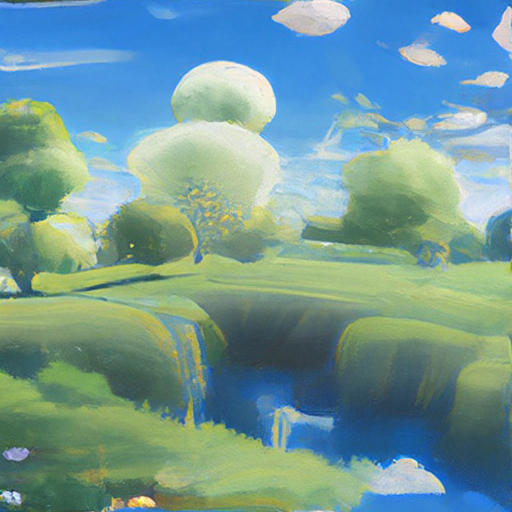

frame_1.png


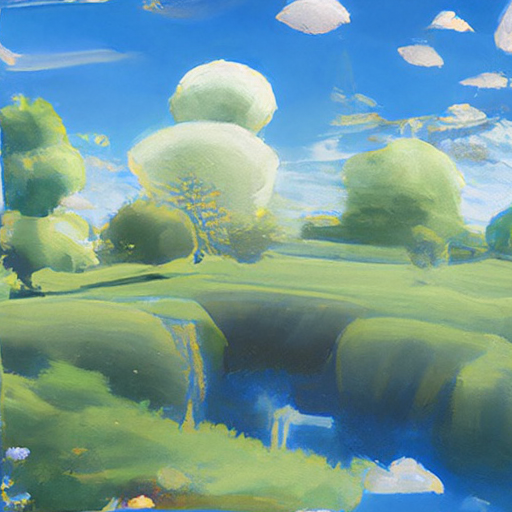

frame_2.png


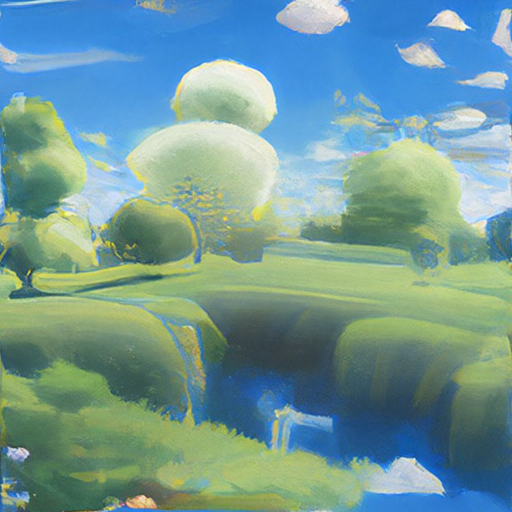

frame_3.png


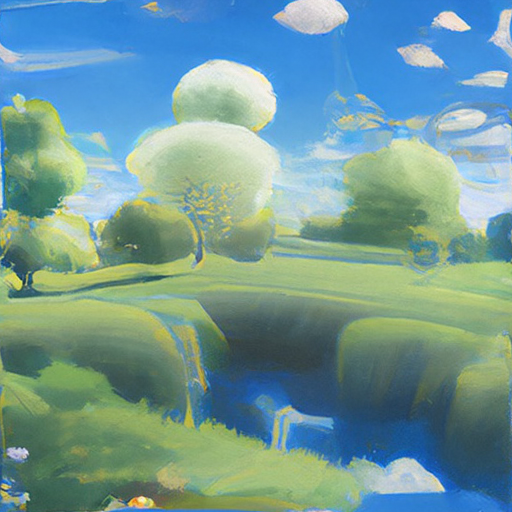

frame_4.png


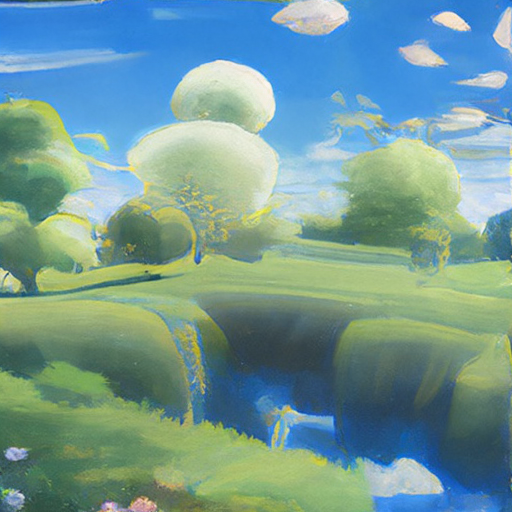

frame_5.png


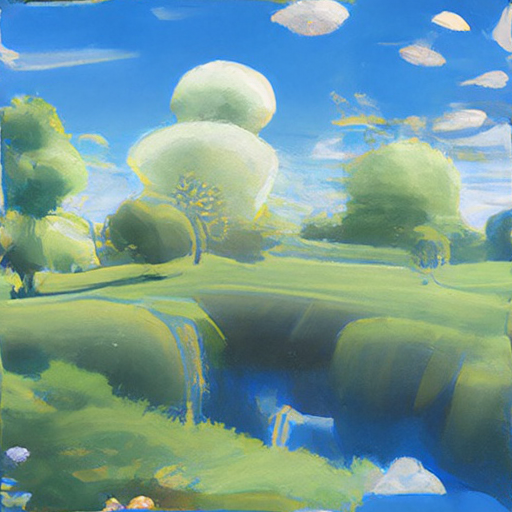

frame_6.png


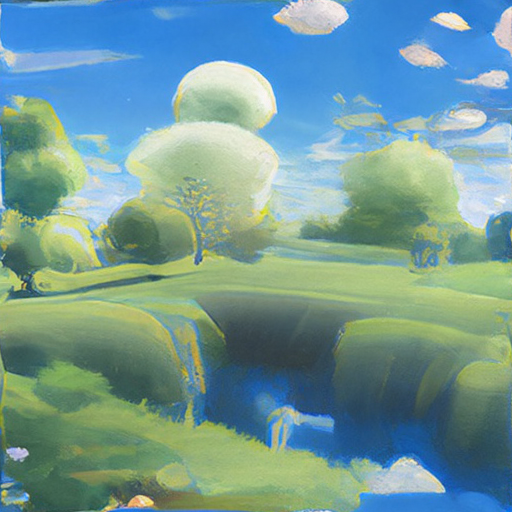

frame_7.png


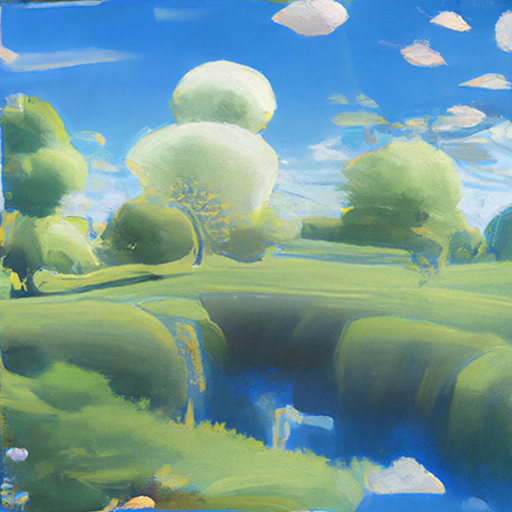

frame_8.png


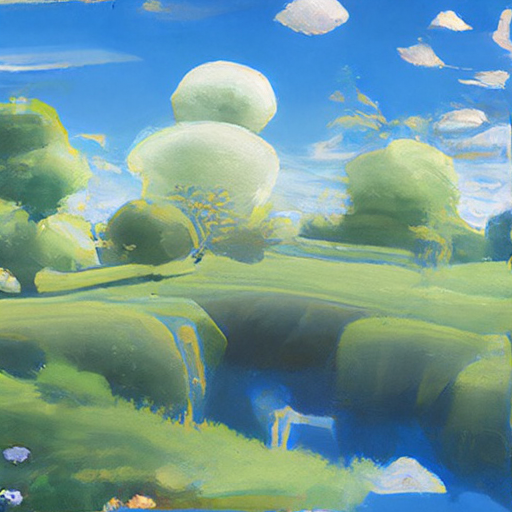

frame_9.png


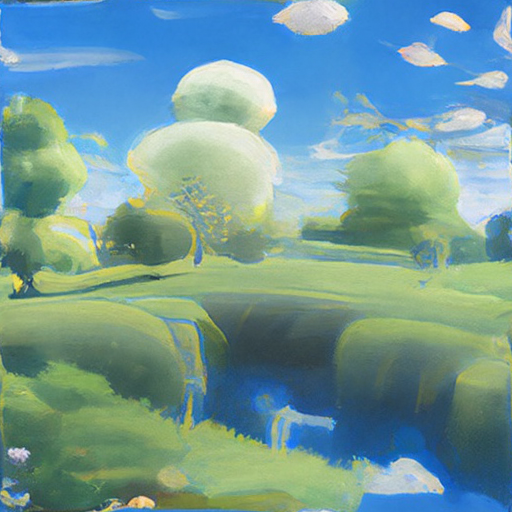

frame_10.png


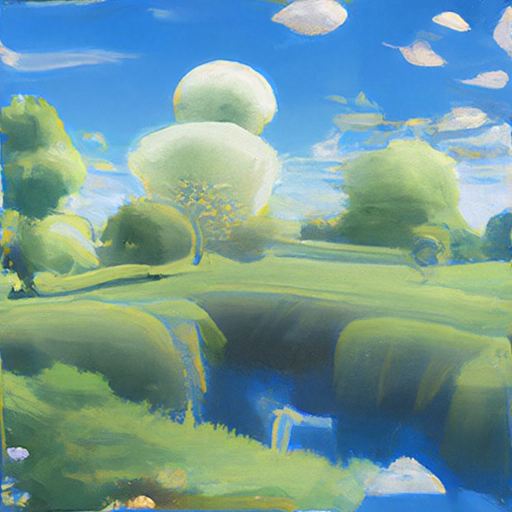

frame_11.png


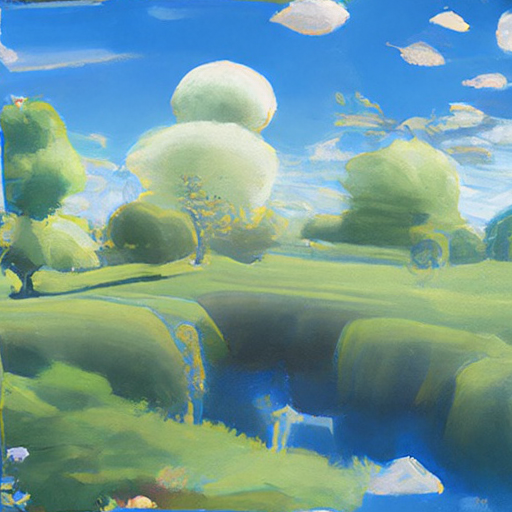

AttributeError: shape

In [8]:
#here's how everything ties together. I feel like there's still more opportunity to make this more readable, maintainable, or useful.


# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-v1-5", # Set the engine to use for generation.
    # Available engines: stable-diffusion-v1 stable-diffusion-v1-5 stable-diffusion-512-v2-0 stable-diffusion-768-v2-0
    # stable-diffusion-512-v2-1 stable-diffusion-768-v2-1 stable-diffusion-xl-beta-v2-2-2 stable-inpainting-v1-0 stable-inpainting-512-v2-0
    upscale_engine="stable-diffusion-x4-latent-upscaler",
)

# generate anchor image for init grid
img = generate_image(
    prompt="expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    seed=992446758, # If a seed is provided, the resulting generated image will be deterministic.
                    # What this means is that as long as all generation parameters remain the same, you can always recall the same image simply by generating it again.
                    # Note: This isn't quite the case for CLIP Guided generations, which we tackle in the CLIP Guidance documentation.
    steps=30, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=512, # Generation width, defaults to 512 if not included.
    height=512, # Generation height, defaults to 512 if not included.
    samples=1, # Number of images to generate, defaults to 1 if not included.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

# build init grid
image_grid = image_to_grid(img)

seed=12345678


frame_idx=0
k=4

#########################################################

def step_image_grid(
    image_grid,
    k,
    prev_img=None
):

    # apply diffusion step to image grid
    image_grid2 = generate_image(
        init_image = image_grid,
        start_schedule=0.2,
        #########################
        prompt="expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
        steps=30,
        cfg_scale=8.0,
        width=512,
        height=512,
        samples=1,
        seed=seed,
        sampler=generation.SAMPLER_K_DPMPP_2M
    )

    # upscale generation
    image_grid3 = upscale_image(
        init_image = image_grid2,
        #start_schedule=0.2,
        #########################
        prompt="expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
        steps=30,
        cfg_scale=8.0,
        width=512*4,
        #height=512,
        #samples=1,
        seed=seed,
        #sampler=generation.SAMPLER_K_DPMPP_2M
    )


    imlist3 = demultiplex(np.array(image_grid3), K=k) # (16, 512, 512, 3)

    # sort grid images

    im_vectors = rearrange(imlist3, "b h w c -> b (h w c)") # (16, 786432)
    dmat = pdist(im_vectors, metric='cosine') # 120
    dmat2 = squareform(dmat) # 16 16
    distance_matrix = dmat2[:]
    np.fill_diagonal(distance_matrix, 1)

    num_fixed=0
    row_indices, col_indices = linear_sum_assignment(distance_matrix[num_fixed:, num_fixed:])
    sorted_order = torch.cat([torch.arange(num_fixed), torch.as_tensor(col_indices + num_fixed)])
    images = imlist3[sorted_order] # images.shape
    images = [Image.fromarray(v) for v in images]    

    return images
    
def process_images(images, k, frame_idx):

    frozen_partition, dynamic_partition = images[:-k], images[-k:]

    for img in frozen_partition:
        img_path = f"frame_{frame_idx}.png"
        print(img_path)
        display(img)
        img.save(img_path)
        frame_idx+=1
    prev_img = img

    next_grid_images = []
    for _ in range(k):
        next_grid_images.extend(dynamic_partition)
    imlist = [np.array(im) for im in next_grid_images]
    next_grid = multiplex(imlist, K=k)
    image_grid = Image.fromarray(np.squeeze(next_grid.astype(np.uint8)))

    # I think we need to shrink the new grid, since it's now at upscaled resolution
    print(image_grid.size)

    image_grid = image_grid.resize((512,512))
    return image_grid, frame_idx, prev_img

    
    
images = step_image_grid(image_grid, k)
image_grid, frame_idx, prev_img = process_images(images, k, frame_idx)
    
#for im in images:
#    display(im)

### to do: rinse and repeat to build up an animation from frozen frames

---

In [9]:
image_grid.size

(2048, 2048)

---

In [ ]:
# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-v1-5", # Set the engine to use for generation.
    # Available engines: stable-diffusion-v1 stable-diffusion-v1-5 stable-diffusion-512-v2-0 stable-diffusion-768-v2-0
    # stable-diffusion-512-v2-1 stable-diffusion-768-v2-1 stable-diffusion-xl-beta-v2-2-2 stable-inpainting-v1-0 stable-inpainting-512-v2-0
    upscale_engine="stable-diffusion-x4-latent-upscaler",
)

In [ ]:
img = generate_image(
    prompt="expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    seed=992446758, # If a seed is provided, the resulting generated image will be deterministic.
                    # What this means is that as long as all generation parameters remain the same, you can always recall the same image simply by generating it again.
                    # Note: This isn't quite the case for CLIP Guided generations, which we tackle in the CLIP Guidance documentation.
    steps=30, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=512, # Generation width, defaults to 512 if not included.
    height=512, # Generation height, defaults to 512 if not included.
    samples=1, # Number of images to generate, defaults to 1 if not included.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

img

In [ ]:
image_grid = image_to_grid(img)
image_grid

In [ ]:
seed=12345678

# apply diffusion step to image grid
image_grid2 = generate_image(
    init_image = image_grid,
    start_schedule=0.2,
    #########################
    prompt="expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    steps=30,
    cfg_scale=8.0,
    width=512,
    height=512,
    samples=1,
    seed=seed,
    sampler=generation.SAMPLER_K_DPMPP_2M
)

# upscale generation
image_grid3 = upscale_image(
    init_image = image_grid2,
    #start_schedule=0.2,
    #########################
    prompt="expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    steps=30,
    cfg_scale=8.0,
    width=512*4,
    #height=512,
    #samples=1,
    seed=seed,
    #sampler=generation.SAMPLER_K_DPMPP_2M
)

image_grid3

In [ ]:

imlist3 = demultiplex(np.array(image_grid3), K=4)

#imlist3.shape # (16, 512, 512, 3)

im_vectors = rearrange(imlist3, "b h w c -> b (h w c)")

#im_vectors.shape # (16, 786432)

dmat = pdist(im_vectors, metric='cosine')
dmat.shape # 120
dmat2 = squareform(dmat)
dmat2.shape # 16 16

distance_matrix = dmat2[:]
np.fill_diagonal(distance_matrix, 1)


num_fixed=0

row_indices, col_indices = linear_sum_assignment(distance_matrix[num_fixed:, num_fixed:])

# Add the fixed indices back to get the final sorted order
sorted_order = torch.cat([torch.arange(num_fixed), torch.as_tensor(col_indices + num_fixed)])

images = imlist3[sorted_order] # images.shape


In [ ]:
images.shape

In [ ]:
images = [Image.fromarray(v) for v in images]    

In [ ]:

mask, frozen_partition, dynamic_partition = partition_grid(images)

#mask

In [ ]:

for im in images:
    display(im)

---

In [ ]:
# to do: let's add transforms i guess? do it without transforms first. 

---

In [ ]:
# chatgpt guessing at how to loop this.

num_rounds = 5  # Number of rounds of diffusion and animation generation
num_frozen_frames = 6  # Number of frozen frames per round

frozen_frames = deepcopy(frozen_partition)  # Initialize the frozen frames with initial frozen partition

for round in range(num_rounds):
    print(f"Generating Animation - Round {round + 1}")

    # Set the initial image grid as the current frozen frames
    initial_image_grid = image_to_grid(frozen_frames, k=4, downsample=False)

    # Apply diffusion step to the image grid
    diffusion_params["init_image"] = initial_image_grid
    diffused_image_grid = generate_image(diffusion_params)

    # Upscale the diffused image
    upscale_params["init_image"] = diffused_image_grid
    upscaled_image_grid = upscale_image(upscale_params)

    # Demultiplex the upscaled image grid
    demultiplexed_images = demultiplex(np.array(upscaled_image_grid), K=4)

    # Calculate pairwise cosine distances
    image_vectors = rearrange(demultiplexed_images, "b h w c -> b (h w c)")
    distance_matrix = pdist(image_vectors, metric='cosine')
    distance_matrix = squareform(distance_matrix)
    np.fill_diagonal(distance_matrix, 1)

    # Perform TSP sort with the appropriate number of fixed frames
    row_indices, col_indices = linear_sum_assignment(distance_matrix[num_frozen_frames:, num_frozen_frames:])
    sorted_order = torch.cat([torch.arange(num_frozen_frames), torch.as_tensor(col_indices + num_frozen_frames)])
    sorted_images = demultiplexed_images[sorted_order]

    # Update the frozen frames with the desired number of frames
    frozen_frames = sorted_images[:num_frozen_frames]

    # Display or save the generated frames as needed
    for frame in sorted_images:
        display(Image.fromarray(frame))

    print("Round Complete\n")

print("Animation Generation Complete")


In [ ]:
# let's try that again

# def image_to_grid(images: list, k: int = 4, downsample: bool = False) -> Image.Image:
#     """
#     Convert a list of images to a grid by rearranging them into a KxK grid.

#     Parameters
#     ----------
#     images: list
#         The input list of images to convert to a grid.
#     k: int, optional (default=4)
#         The size of the grid (KxK).
#     downsample: bool, optional (default=False)
#         Whether to downsample the images before creating the grid.

#     Returns
#     -------
#     PIL.Image.Image
#         The images arranged in a KxK grid.

#     Notes
#     -----
#     - The input images can be downsampled before creating the grid.
#     - The resulting grid will have dimensions (k, k) times smaller than the original images.
#     """
#     if downsample:
#         resized_images = [Image.fromarray(image).resize((image.shape[0] // k, image.shape[1] // k)) for image in images]
#     else:
#         resized_images = [Image.fromarray(image) for image in images]

#     gridded = multiplex(resized_images, K=k)
#     image_grid = Image.fromarray(np.squeeze(gridded.astype(np.uint8)))

#     return image_grid

def image_to_grid(images: list, k: int = 4, downsample: bool = False) -> Image.Image:
    """
    Convert a list of images to a grid by rearranging them into a KxK grid.

    Parameters
    ----------
    images: list
        The input list of images to convert to a grid.
    k: int, optional (default=4)
        The size of the grid (KxK).
    downsample: bool, optional (default=False)
        Whether to downsample the images before creating the grid.

    Returns
    -------
    PIL.Image.Image
        The images arranged in a KxK grid.

    Notes
    -----
    - The input images can be downsampled before creating the grid.
    - The resulting grid will have dimensions (k, k) times smaller than the original images.
    """
    if downsample:
        resized_images = [np.array(image.resize((image.size[0] // k, image.size[1] // k))) for image in images]
    else:
        resized_images = [np.array(image) for image in images]

    gridded = multiplex(resized_images, K=k)
    image_grid = Image.fromarray(np.squeeze(gridded.astype(np.uint8)))

    return image_grid


# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'],
    verbose=True,
    engine="stable-diffusion-v1-5",
    upscale_engine="stable-diffusion-x4-latent-upscaler"
)

# Generate initial image
initial_img_params = {
    "prompt": "expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    "seed": 992446758,
    "steps": 30,
    "cfg_scale": 8.0,
    "width": 512,
    "height": 512,
    "samples": 1,
    "sampler": generation.SAMPLER_K_DPMPP_2M
}

initial_image = generate_image(**initial_img_params)

# Convert initial image to grid
initial_image_grid = image_to_grid([initial_image], k=4, downsample=False)

seed = 12345678

# Apply diffusion step to the image grid
diffusion_params = {
    "init_image": initial_image_grid,
    "start_schedule": 0.2,
    "prompt": "expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    "steps": 30,
    "cfg_scale": 8.0,
    "width": 512,
    "height": 512,
    "samples": 1,
    "seed": seed,
    "sampler": generation.SAMPLER_K_DPMPP_2M
}

diffused_image_grid = generate_image(diffusion_params)

# Upscale the diffused image
# Upscale the diffused image
upscale_params = {
    "init_image": diffused_image_grid,
    "prompt": "expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    "steps": 30,
    "cfg_scale": 8.0,
    "width": 512 * 4,
    "seed": seed,
}

upscaled_image_grid = upscale_image(upscale_params)

# Demultiplex the upscaled image grid
demultiplexed_images = demultiplex(np.array(upscaled_image_grid), K=4)

# Calculate pairwise cosine distances
image_vectors = rearrange(demultiplexed_images, "b h w c -> b (h w c)")
distance_matrix = pdist(image_vectors, metric='cosine')
distance_matrix = squareform(distance_matrix)
np.fill_diagonal(distance_matrix, 1)

num_fixed = 0

for round in range(num_rounds):
    print(f"Generating Animation - Round {round + 1}")

    # Set the initial image grid as the current frozen frames
    initial_image_grid = image_to_grid(frozen_frames, k=4, downsample=False)

    # Apply diffusion step to the image grid
    diffusion_params["init_image"] = initial_image_grid
    diffused_image_grid = generate_image(diffusion_params)

    # Upscale the diffused image
    upscale_params["init_image"] = diffused_image_grid
    upscaled_image_grid = upscale_image(upscale_params)

    # Demultiplex the upscaled image grid
    demultiplexed_images = demultiplex(np.array(upscaled_image_grid), K=4)

    # Calculate pairwise cosine distances
    image_vectors = rearrange(demultiplexed_images, "b h w c -> b (h w c)")
    distance_matrix = pdist(image_vectors, metric='cosine')
    distance_matrix = squareform(distance_matrix)
    np.fill_diagonal(distance_matrix, 1)

    # Perform TSP sort with the appropriate number of fixed frames
    row_indices, col_indices = linear_sum_assignment(distance_matrix[num_fixed:, num_fixed:])
    sorted_order = torch.cat([torch.arange(num_fixed), torch.as_tensor(col_indices + num_fixed)])
    sorted_images = demultiplexed_images[sorted_order]

    # Update the frozen frames with the desired number of frames
    frozen_frames = sorted_images[:num_frozen_frames]

    # Display or save the generated frames as needed
    for frame in sorted_images:
        display(Image.fromarray(frame))

    print("Round Complete\n")

print("Animation Generation Complete")



In [ ]:
# def image_to_grid(images: list, k: int = 4, downsample: bool = False) -> Image.Image:
#     """
#     Convert a list of images to a grid by rearranging them into a KxK grid.

#     Parameters
#     ----------
#     images: list
#         The input list of images to convert to a grid.
#     k: int, optional (default=4)
#         The size of the grid (KxK).
#     downsample: bool, optional (default=False)
#         Whether to downsample the images before creating the grid.

#     Returns
#     -------
#     PIL.Image.Image
#         The images arranged in a KxK grid.

#     Notes
#     -----
#     - The input images can be downsampled before creating the grid.
#     - The resulting grid will have dimensions (k, k) times smaller than the original images.
#     """
#     if downsample:
#         resized_images = [np.array(image.resize((image.size[0] // k, image.size[1] // k))) for image in images]
#     else:
#         resized_images = [np.array(image) for image in images]

#     gridded = multiplex(resized_images, K=k)
#     image_grid = Image.fromarray(np.squeeze(gridded.astype(np.uint8)))

#     return image_grid

def image_to_grid(images: list, k: int = 4, downsample: bool = False) -> Image.Image:
    """
    Convert a list of images to a grid by rearranging them into a KxK grid.

    Parameters
    ----------
    images: list
        The input list of images to convert to a grid.
    k: int, optional (default=4)
        The size of the grid (KxK).
    downsample: bool, optional (default=False)
        Whether to downsample the images before creating the grid.

    Returns
    -------
    PIL.Image.Image
        The images arranged in a KxK grid.

    Notes
    -----
    - The input images can be downsampled before creating the grid.
    - The resulting grid will have dimensions (k, k) times smaller than the original images.
    """
    if downsample:
        resized_images = [np.array(image.resize((image.size[0] // k, image.size[1] // k))) for image in images]
    else:
        resized_images = [np.array(image) for image in images]

    if len(resized_images) == 1:
        return Image.fromarray(resized_images[0])

    gridded = multiplex(resized_images, K=k)
    image_grid = Image.fromarray(np.squeeze(gridded.astype(np.uint8)))

    return image_grid


# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'],
    verbose=True,
    engine="stable-diffusion-v1-5",
    upscale_engine="stable-diffusion-x4-latent-upscaler"
)

# Generate initial image
initial_img_params = {
    "prompt": "expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    "seed": 992446758,
    "steps": 30,
    "cfg_scale": 8.0,
    "width": 512,
    "height": 512,
    "samples": 1,
    "sampler": generation.SAMPLER_K_DPMPP_2M
}

initial_image = generate_image(**initial_img_params)

# Convert initial image to grid
initial_image_grid = image_to_grid([initial_image], k=4, downsample=False)

seed = 12345678

# Apply diffusion step to the image grid
diffusion_params = {
    "init_image": initial_image_grid,
    "start_schedule": 0.2,
    "prompt": "expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    "steps": 30,
    "cfg_scale": 8.0,
    "width": 512,
    "height": 512,
    "samples": 1,
    "seed": seed,
    "sampler": generation.SAMPLER_K_DPMPP_2M
}

diffused_image_grid = generate_image(**diffusion_params)

# Upscale the diffused image
upscale_params = {
    "init_image": diffused_image_grid,
    "prompt": "expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    "steps": 30,
    "cfg_scale": 8.0,
    "width": 512 * 4,
    "seed": seed,
}

upscaled_image_grid = upscale_image(**upscale_params)

# Demultiplex the upscaled image grid
demultiplexed_images = demultiplex(np.array(upscaled_image_grid), K=4)

# Calculate pairwise cosine distances
image_vectors = rearrange(demultiplexed_images, "b h w c -> b (h w c)")
distance_matrix = pdist(image_vectors, metric='cosine')
distance_matrix = squareform(distance_matrix)
np.fill_diagonal(distance_matrix, 1)

num_fixed = 0

all_frames = []

for round in range(num_rounds):
    print(f"Generating Animation - Round {round + 1}")

    # Set the initial image grid as the current frozen frames
    #initial_image_grid = image_to_grid(frozen_frames, k=4, downsample=False)
    im_seq = []
    for _ in range(4): # range(len(frozen_frames)): ?
        im_seq.extend(frozen_frames)
    im_seq = [Image.fromarray(f) for f in im_seq]
    #initial_image_grid = image_to_grid(im_seq, k=4, downsample=False)
    #initial_image_grid = image_to_grid(im_seq, k=4, downsample=(round>0))
    initial_image_grid = image_to_grid(im_seq, k=4, downsample=True)
    print(initial_image_grid.size)

    # Apply diffusion step to the image grid
    diffusion_params["init_image"] = initial_image_grid
    diffused_image_grid = generate_image(**diffusion_params)

    # Upscale the diffused image
    upscale_params["init_image"] = diffused_image_grid
    upscaled_image_grid = upscale_image(**upscale_params)

    # Demultiplex the upscaled image grid
    demultiplexed_images = demultiplex(np.array(upscaled_image_grid), K=4)

    # Calculate pairwise cosine distances
    image_vectors = rearrange(demultiplexed_images, "b h w c -> b (h w c)")
    distance_matrix = pdist(image_vectors, metric='cosine')
    distance_matrix = squareform(distance_matrix)
    np.fill_diagonal(distance_matrix, 1)

    # Perform TSP sort with the appropriate number of fixed frames
    row_indices, col_indices = linear_sum_assignment(distance_matrix[num_fixed:, num_fixed:])
    sorted_order = torch.cat([torch.arange(num_fixed), torch.as_tensor(col_indices + num_fixed)])
    sorted_images = demultiplexed_images[sorted_order]

    # Update the frozen frames with the desired number of frames
    frozen_frames = sorted_images[:num_frozen_frames]

    # Display or save the generated frames as needed
    #for frame in sorted_images:
    for frame in frozen_frames:
        frame = Image.fromarray(frame)
        display(frame)
        all_frames.append(frame)

    print("Round Complete\n")

print("Animation Generation Complete")
# ```

# In this updated code, the `image_to_grid()` function has been modified to handle resizing and grid creation outside the loop, ensuring consistent image shapes for each iteration. Additionally, the code for generating animation frames has been provided, including the freezing of frames, diffusion steps, and TSP-based sorting of images.

# Please note that the code assumes the availability of the required functions and libraries, and it may need further adjustments based on the specifics of your environment and requirements.


In [ ]:
im_seq[0]